# データの確認
日本取引所の公開しているデータから，日経225の2021年6限月(つまり原資産を日経225とし，2021年6月の第二金曜日に満期を迎えるオプション)の，2021年4月28日における終値を抽出した．
データは`data_20210428.csv`に入っており，各列のラベルは以下を意味している：
* `K`は行使価額
* `put_value_market`はプットオプションの市場価格
* `call_value_market`はコールオプションの市場価格

ただしオプションの市場価格の数値について，取引がなかったものについて価格はおそらく`0`と評価されている．
そのため，プット・コールのそれぞれに対し`0`でない市場価格を持つような行使価額のみを取り出すことにし，`df_put`，`df_call`とした．

In [1]:
import pandas as pd
df = pd.read_csv("data_20210428.csv")
df_put = df[df["put_value_market"] != 0]
df_call = df[df["call_value_market"] != 0]
print(df_call)

         K  put_value_market  call_value_market
83   28750               550                805
84   28875               595                800
85   29000               645                700
86   29125               755                645
87   29250               720                590
88   29375                 0                510
89   29500                 0                455
90   29625                 0                430
91   29750                 0                355
92   29875                 0                325
93   30000                 0                275
94   30125                 0                245
95   30250                 0                215
96   30375                 0                195
97   30500                 0                155
98   30625                 0                135
99   30750                 0                125
100  30875                 0                100
101  31000                 0                 87
102  31125                 0            

# ニュートン法によるインプライド・ボラティリティの計算
コールオプションの市場価格を$c^*$とすると，ニュートン法
$$
\sigma_t = \sigma_{t-1} - \dfrac{c(K, \sigma_{t-1}) - c^*}{\nu(K, \sigma_{t-1}}
$$
によってインプライド・ボラティリティを計算することができる．
ただし$\nu(K, \sigma_{t-1})$はベガと呼ばれる量で，
$$
\nu(K, \sigma) = \dfrac{\partial c}{\partial \sigma} = S(0) \sqrt{T} \dfrac{1}{\sqrt{2\pi}} \exp \left[ -d_+^2 / 2 \right]
$$
のように計算できる．$d_+$の計算方法は本文参照．
さらに，プットオプションのベガもコールオプションと同じ式で計算できるから，ほとんど同様に実装できる．

In [2]:
import numpy as np
from scipy.stats import norm 

S0 = 29053.97 # initial stock price
r = 0.0025 # interest rate / year
T = 44 / 365.0 # 1 year

class European_call:
    def __init__(self, S0, r, T):
        self.S0 = S0
        self.r = r
        self.T = T
        
    def get_d_list(self, K, vol):
        d_plus = (1.0 / (vol*np.sqrt(self.T))) * (np.log(self.S0/K) + (self.r+0.5*vol*vol)*self.T)
        d_minus = (1.0 / (vol*np.sqrt(self.T))) * (np.log(self.S0/K) + (self.r-0.5*vol*vol)*self.T)
        return [d_plus, d_minus]
    
    def get_value(self, K, vol):
        d_plus, d_minus = self.get_d_list(K, vol)
        return self.S0*norm.cdf(d_plus) - K*np.exp(-self.r*self.T)*norm.cdf(d_minus)
    
    def get_vega(self, K, vol):
        d_plus, d_minus = self.get_d_list(K, vol)
        return self.S0*np.sqrt(T)*(1.0/np.sqrt(2.0*np.pi))*np.exp(-0.5*d_plus*d_plus)
    
    def get_implied_vol(self, c_actual, K, num_iteration = 80): # c_actual:コールオプションの市場価格
        implied_vol = 1.6 # 小さい値を取るとvegaが0になってしまい，ニュートン法に支障をきたす．
        for idx in range(num_iteration):
            # ニュートン法により，オプションの理論値と市場価格が等しくなるようなsigma_impliedを求める．
            implied_vol = implied_vol - (self.get_value(K, implied_vol)-c_actual) / self.get_vega(K, implied_vol)
        return implied_vol

class European_put:
    def __init__(self, S0, r, T):
        self.S0 = S0
        self.r = r
        self.T = T
        
    def get_d_list(self, K, vol):
        d_plus = (1.0 / (vol*np.sqrt(self.T))) * (np.log(self.S0/K) + (self.r+0.5*vol*vol)*self.T)
        d_minus = (1.0 / (vol*np.sqrt(self.T))) * (np.log(self.S0/K) + (self.r-0.5*vol*vol)*self.T)
        return [d_plus, d_minus]
    
    def get_value(self, K, vol):
        d_plus, d_minus = self.get_d_list(K, vol)
        return -self.S0*norm.cdf(-d_plus) + K*np.exp(-self.r*self.T)*norm.cdf(-d_minus)
    
    def get_vega(self, K, vol):
        d_plus, d_minus = self.get_d_list(K, vol)
        return self.S0*np.sqrt(T)*(1.0/np.sqrt(2.0*np.pi))*np.exp(-0.5*d_plus*d_plus)
    
    def get_implied_vol(self, p_actual, K, num_iteration = 80): # p_actual:プットオプションの市場価格
        implied_vol = 1.6 # 小さい値を取るとvegaが0になってしまい，ニュートン法に支障をきたす．
        for idx in range(num_iteration):
            # ニュートン法により，オプションの理論値と市場価格が等しくなるようなimplied_volを求める．
            implied_vol = implied_vol - (self.get_value(K, implied_vol)-p_actual) / self.get_vega(K, implied_vol)
        return implied_vol
option = European_call(S0, r, T)
option.get_value(30875, 0.152869)

100.75265958902173

# ボラティリティ・スマイルの確認
実際の市場価格を使い，ボラティリティ・スマイルを確認する．なお，元データから測定時点での原資産価格は$S_0 = 29053.97$とわかっている．また金利は$r = 0.0$とみなしてよく，満期までの時間を計算すると$44$日なので$T = 44 / 365$とした．

In [3]:
# parameters
S0 = 29053.97 # initial stock price
r = 0.00 # interest rate / year
T = 44 / 365.0 # 1 year

option = European_call(S0, r, T) # まずはコールオプションから調べる
vol_for_call = np.zeros(len(df_call)) # コールオプションの市場価格から求めたインプライド・ボラティリティを格納する

for num, idx in enumerate(df_call.index):
    K = df_call.at[idx, "K"] # 行使価額のデータを取り出す
    c_actual = df_call.at[idx, "call_value_market"] # 市場価格のデータを取り出す
    vol_for_call[num] = option.get_implied_vol(c_actual, K) # インプライド・ボラティリティを計算

option = European_put(S0, r, T) # 次はプットオプション
vol_for_put = np.zeros(len(df_put))

for num, idx in enumerate(df_put.index):
    K = df_put.at[idx, "K"]
    p_actual = df_put.at[idx, "put_value_market"]
    vol_for_put[num] = option.get_implied_vol(p_actual, K)

グラフに示す．満期が短い株式オプションに典型的にみられる性質が反映されている．

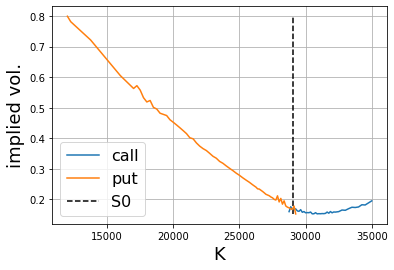

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(df_call["K"], vol_for_call, label = "call")
plt.plot(df_put["K"], vol_for_put, label = "put")
#plt.plot(df["K"], df["vol_call"], label = "implied_vol_data")
plt.grid()
plt.vlines(S0, min(vol_for_call), max(vol_for_put), linestyles = "dashed", color = "black", label = "S0")
plt.xlabel("K",size = 18)
plt.ylabel("implied vol.",size = 18)
plt.legend(bbox_to_anchor = (0,0), loc = "lower left", fontsize = 16)
plt.savefig("implied_vol.pdf")

# おまけ：fitting

In [169]:
'''
x_train = np.array(df_call["K"])
x_train_normalized = (x_train - x_train.mean()) / x_train.std()
x_test_normalized = np.linspace(min(x_train_normalized), max(x_train_normalized), len(x_train_normalized)*4)
y_train = vol_for_call
y_train_normalized = (y_train - y_train.mean()) / y_train.std()
print(x_train_normalized)
'''


# プットとコールの行使価額のデータを結合する
x_train = np.zeros(len(df_call) + len(df_put))
x_train[0:len(df_call)] = np.array(df_call["K"])
x_train[len(df_call):] = np.array(df_put["K"])
# ガウス過程回帰しやすいように標準化
x_train_normalized = (x_train - x_train.mean()) / x_train.std()
# 行使価額のデータよりも細かい点で回帰を行う
x_test_normalized = np.linspace(min(x_train_normalized), max(x_train_normalized), len(x_train_normalized)*4)
x_test = np.linspace(min(x_train), max(x_train), len(x_train)*4)

# インプライド・ボラティリティについても同様
y_train = np.zeros(len(x_train))
y_train[0:len(df_call)] = vol_for_call
y_train[len(df_call):] = vol_for_put
y_train_normalized = (y_train - y_train.mean()) / y_train.std()
print(x_train_normalized)

[ 4.44149259e-01  4.67622433e-01  4.91095606e-01  5.14568779e-01
  5.38041953e-01  5.61515126e-01  5.84988299e-01  6.08461473e-01
  6.31934646e-01  6.55407819e-01  6.78880992e-01  7.02354166e-01
  7.25827339e-01  7.49300512e-01  7.72773686e-01  7.96246859e-01
  8.19720032e-01  8.43193205e-01  8.66666379e-01  8.90139552e-01
  9.13612725e-01  9.37085899e-01  9.60559072e-01  9.84032245e-01
  1.00750542e+00  1.03097859e+00  1.05445177e+00  1.07792494e+00
  1.10139811e+00  1.14834446e+00  1.19529080e+00  1.24223715e+00
  1.28918350e+00  1.33612984e+00  1.38307619e+00  1.43002254e+00
  1.47696888e+00  1.52391523e+00  1.61780792e+00 -2.70125596e+00
 -2.65430962e+00 -2.37263154e+00 -1.95011442e+00 -1.76232903e+00
 -1.71538268e+00 -1.66843634e+00 -1.62148999e+00 -1.57454364e+00
 -1.52759730e+00 -1.48065095e+00 -1.43370460e+00 -1.38675826e+00
 -1.29286556e+00 -1.24591922e+00 -1.19897287e+00 -1.15202652e+00
 -1.10508018e+00 -1.05813383e+00 -1.01118748e+00 -9.64241138e-01
 -9.17294792e-01 -8.70348

In [233]:
M = 10
def phi(x):#基底関数:ガウス関数
    h = (max(x_test_normalized)-min(x_test_normalized)) / M
    return np.exp(-(x - np.linspace(min(x_test_normalized), max(x_test_normalized), M))**2/(2*h **2))

Phi = np.array([phi(x) for x in x_train_normalized])    #ガウス関数の計画行列
print(Phi.shape)

alpha = 0.01
beta = 0.05

S = np.linalg.inv(alpha * np.eye(M) + beta * Phi.T.dot(Phi))    #ガウス関数の分散
m = beta * S.dot(Phi.T).dot(y_train_normalized)     #ガウス関数の平均

mu = [m.dot(phi(x_)) for x_ in x_test_normalized]
mu = np.array(mu)
std = [np.sqrt( beta+phi(x_).T.dot(S).dot(phi(x_)) ) for x_ in x_test_normalized]
std = np.array(std)

(102, 10)


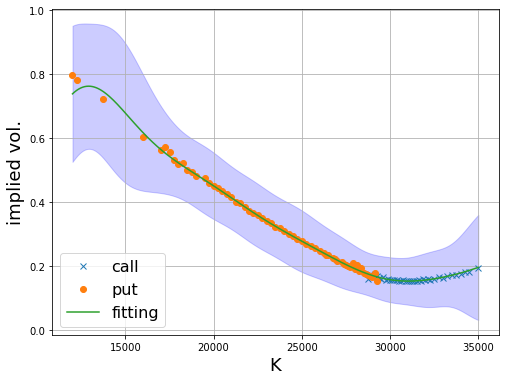

In [234]:
plt.figure(figsize=(8, 6))
plt.plot(df_call["K"], vol_for_call,"x", label = "call")
plt.plot(df_put["K"], vol_for_put, "o", label = "put")
#plt.plot(x_train, y_train, "x", color = "green", label = "data")
mu = y_train.mean() + mu*y_train.std()
std = std*y_train.std()
plt.plot(x_test, mu, label = "fitting")
plt.fill_between(x_test, mu + 0.5*std, mu - 0.5*std, alpha=.2, color='blue')
plt.xlabel("K",size = 18)
plt.ylabel("implied vol.",size = 18)
#plt.xlim([])
plt.legend(bbox_to_anchor = (0,0), loc = "lower left", fontsize = 16)
plt.grid()
plt.savefig("implied_vol_fitting.pdf")